### 1. Przygotowanie środowiska

In [1]:
include("program.jl");
using Random
using ForwardDiff
using Statistics
rng = MersenneTwister(1234);

### 2. Generowanie funkcji testowych
Będę korzystał z 4 rodzin funkcji:
1. Funkcje postaci $f'(x)$, gdzie $f(x) = \sum_i \alpha_i exp(-(\frac{x-\mu_i}{\sigma_i})^2)$
2. Funkcje postaci $f'(x)$, gdzie $f(x) = \sum_i \alpha_i cos(a_i x^3 + b_i x^2 + c_i x + d_i)$
3. Funkcje przedziałami stałe o zbiorze wartości $\{0, 1\}$ (funkcje prostokątne)
4. Funkcje będące sumą funkcji z pierwszego punktu i funkcji prostokątnej

In [2]:
deriv(f) = x -> ForwardDiff.derivative(f, x)

fsum(fs) = x -> sum(f(x) for f in fs)

function get_random_gaussian_mixtures_and_integrals(n, deg)
    means  =  rand(rng, Float64, (n, deg)) .* 2 .- 1
    stddis = randn(rng, Float64, (n, deg)) .* 4
    coeffs = randn(rng, Float64, (n, deg))
    make_elem(m, s, c) = x -> c*exp(-((m-x)*s)^2)
    elems = map(make_elem, means, stddis, coeffs)
    mixes = vec(mapslices(fsum, elems, dims=2))
    dmixes = map(deriv, mixes)
    integrals = map(mix -> mix(1)-mix(-1), mixes)
    return dmixes, integrals
end

function get_random_trig_mixes_and_integrals(n, elems)
    coeffs = randn(rng, Float64, (n, elems)) .*0.3
    freq3  = randn(rng, Float64, (n, elems)) .*0.1
    freq2  = randn(rng, Float64, (n, elems)) .*2
    freq1  = randn(rng, Float64, (n, elems)) .*4
    biases =  rand(rng, Float64, (n, elems)) .*2*pi
    make_elem(c, f3, f2, f1, b) = x -> c*cos(f3*x^3+f2*x^2+f1*x+b)
    elems = map(make_elem, coeffs, freq3, freq2, freq1, biases)
    mixes = vec(mapslices(fsum, elems, dims=2))
    dmixes = map(deriv, mixes)
    integrals = map(mix -> mix(1)-mix(-1), mixes)
    return dmixes, integrals
end

function get_random_rects_and_integrals(n, edges)
    breaks = rand(rng, Float64, (n, edges)) .*2 .- 1
    lshift = hcat(breaks, ones(n, 1))
    rshift = hcat( .- ones(n, 1), breaks)
    dists  = lshift .- rshift
    make_rect(points) = x -> 1-length(points[points .< x])%2
    rects = vec(mapslices(make_rect, breaks, dims=2))
    integrals = vec(sum(dists[:,1:2:end], dims=2))
    return rects, integrals
end

get_random_rects_and_integrals (generic function with 1 method)

### 3. Podgląd przykładowych funkcji

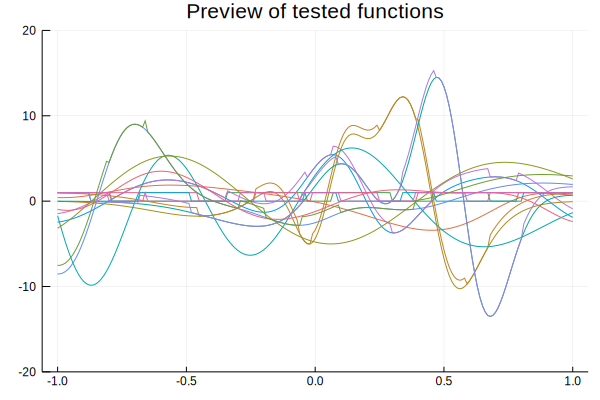

In [3]:
using Plots
num = 1000
mixts, mixtints = get_random_gaussian_mixtures_and_integrals(num, 6)
trigs, trigints = get_random_trig_mixes_and_integrals(num, 8)
rects, rectints = get_random_rects_and_integrals(num, 8)
prcts, prctints = map(fsum, zip(mixts, rects)), mixtints .+ rectints
plot()
for i in 1:4
    mixt = mixts[i]
    trig = trigs[i]
    rect = rects[i]
    prct = prcts[i]
    
    xs = -1:0.01:1
    mys = mixt.(xs)
    tys = trig.(xs)
    rys = rect.(xs)
    qys = prct.(xs)
    
    plot!(xs, mys)
    plot!(xs, tys)
    plot!(xs, rys)
    plot!(xs, qys)
end
plot!(legend=false, title="Preview of tested functions", ylim=(-20, 20))

### 4. Błędy

In [7]:
Ns = 4 .^ (1:5)
funcfamilies = [mixts trigs rects prcts]
ints = [mixtints trigints rectints prctints]

digits_correct(x) = round.(-log2.(abs.(x)); digits=2)

mean_error_digits_correct = Array{Any, 1}(undef, 5)
mini_error_digits_correct = Array{Any, 1}(undef, 5)
maxi_error_digits_correct = Array{Any, 1}(undef, 5)

for i in 1:5
    CC(f) = Clenshaw_Curtis(f, Ns[i])
    errors = abs.((CC.(funcfamilies) .- ints) ./ ints)
    mean_error_digits_correct[i] = digits_correct.(sum(errors, dims=1) ./ num)
    mini_error_digits_correct[i] = digits_correct.(minimum(errors, dims=1))
    maxi_error_digits_correct[i] = digits_correct.(maximum(errors, dims=1))
end


In [8]:
mean_error_digits_correct

5-element Array{Any,1}:
 [-4.08 -3.17 -0.88 -2.76]
 [0.75 14.56 -0.77 -1.26] 
 [28.01 48.72 -0.77 -1.14]
 [48.99 49.0 -0.77 -1.12] 
 [49.6 49.11 -0.77 -1.12] 

In [9]:
maxi_error_digits_correct

5-element Array{Any,1}:
 [-11.05 -9.57 -6.47 -10.75]
 [-7.21 8.41 -6.2 -9.18]    
 [19.8 43.47 -6.1 -8.98]    
 [41.28 43.71 -6.11 -8.9]   
 [42.44 43.85 -6.11 -8.9]   